In [1]:
import sys
sys.path.append("..")

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import GPy

from pyFDA import bspline

In [4]:
%matplotlib inline

In [204]:
def sampleGP(gp,t,size=1):
    mu,cov = gp.predict(t,full_cov=True)
    sample = scipy.stats.multivariate_normal.rvs(mu[:,0],cov,size=size)
    return sample

In [290]:
def poolAdjacentViolators(y):
    z = np.array(y.tolist())
    
    return poolAdjacentViolators_recursive(z,1)

def poolAdjacentViolators_recursive(y,depth=1):
    if depth == y.shape[0]:
        return y
    
    for i in range(y.shape[0]-depth):
        if y[i+depth] < y[i]:
            y[i:i+depth+1] = np.mean(y[i:i+depth+1])
            
    if np.any(y[1:] < y[:-1]):
        return poolAdjacentViolators_recursive(y,depth+1)
    return y

# Prior for the registration function 

In [112]:
def registrationPrior(t0,t1,ratio):

    t = np.array([t0,t1])[:,None]
    mapping = GPy.mappings.Linear(1,1)
    mapping.A = 1
    mapping.A.fix()
    gp = GPy.models.GPRegression(t,t,mean_function=mapping)
    gp.Gaussian_noise=1e-6
    gp.kern.lengthscale= 1.*(t1-t0) * ratio
    return gp

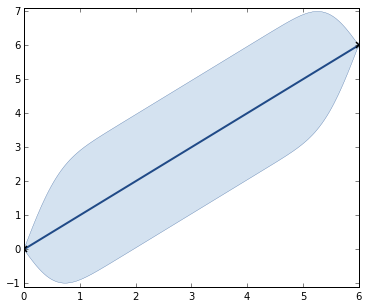

In [197]:
regPrior = registrationPrior(0,6,.1)

fig = plt.figure(figsize=(6,5))
regPrior.plot(fignum=fig.number)
plt.xlim(0,6)
plt.ylim(-1.1,7.1)

plt.savefig("figures/regPrior_likelihood.png")

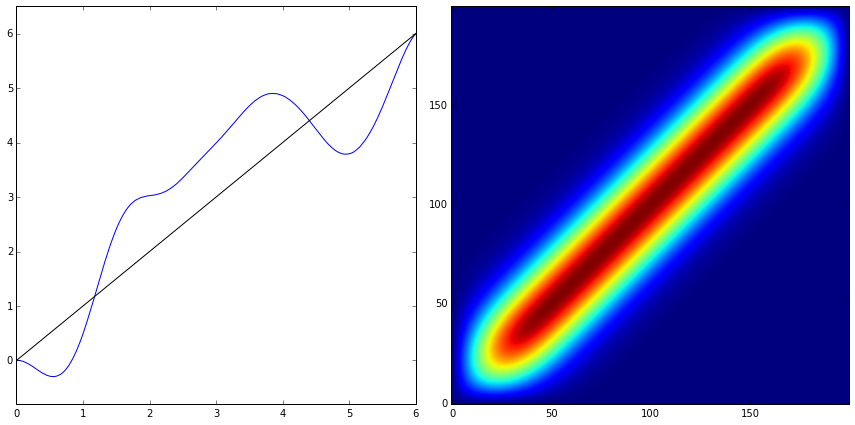

In [287]:
t = np.linspace(0,6,200)
mu,cov = regPrior.predict(t[:,None],full_cov=True)
sample = scipy.stats.multivariate_normal.rvs(mu[:,0],cov)

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(t,sample)
plt.plot(t,t,'k')
plt.ylim(np.min(sample)-.5,np.max(sample)+.5)

plt.subplot(122)
plt.imshow(cov,origin=0)

plt.tight_layout()

plt.savefig("figures/regPrior_sample.png")

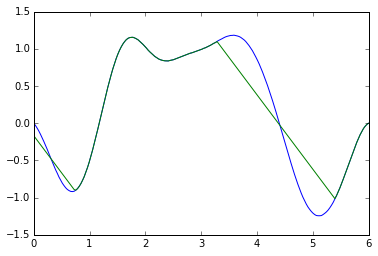

In [291]:
plt.plot(t,sample-t)
plt.plot(t,poolAdjacentViolators(sample)-t)

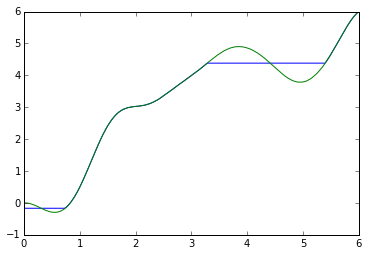

In [292]:
plt.plot(t,poolAdjacentViolators(sample))
plt.plot(t,sample)

# Prior for the mean function

In [159]:
def meanPrior(t0,t1,sigma=.1,lengthscale=1):

    t = np.array([t0,t1])[:,None]
    y = np.array([0,0])[:,None]
    mapping = GPy.mappings.Linear(1,1)
    mapping.A = 0
    mapping.A.fix()
    gp = GPy.models.GPRegression(t,y,mean_function=mapping)
    gp.Gaussian_noise=sigma
    gp.kern.lengthscale= lengthscale
    return gp

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f957ae66110>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f957ae3f7d0>],
  [<matplotlib.lines.Line2D at 0x7f957ae6c610>]]}

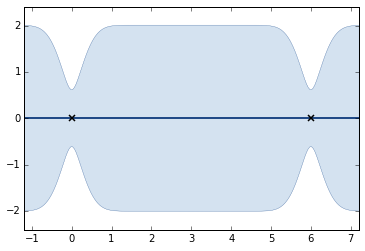

In [160]:
mPrior = meanPrior(0,6,.05,.5)
mPrior.plot()

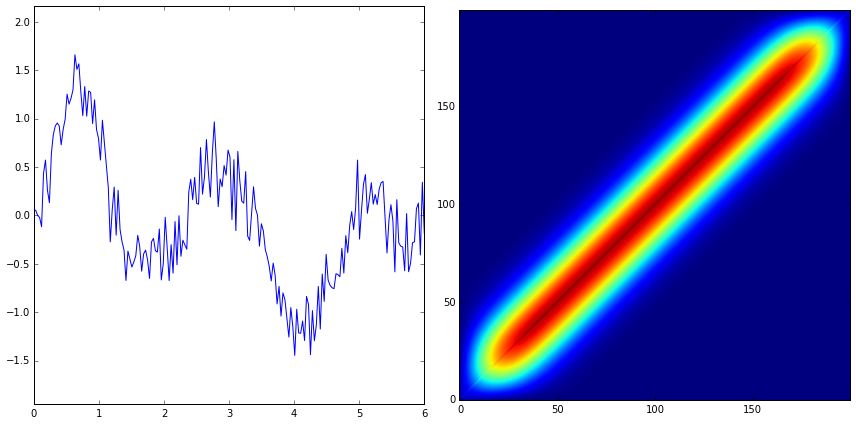

In [161]:
mu,cov = mPrior.predict(t[:,None],full_cov=True)
sample = scipy.stats.multivariate_normal.rvs(mu[:,0],cov)

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(t,sample)
plt.ylim(np.min(sample)-.5,np.max(sample)+.5)

plt.subplot(122)
plt.imshow(cov,origin=0)

plt.tight_layout()

# Example data

In [165]:
def gFunction(t,theta):
	return np.exp(theta[0]) *(t+theta[1])

In [171]:
n = 200
t = np.linspace(0,6,n)

theta1points = .01*((t-3)**2 - 9)
theta1 = bspline.Bspline(t,theta1points)
h = gFunction(t,[theta1(t),0,0])
hspline = bspline.Bspline(t,h)

x = np.cos(t**3/(np.pi**2))
y = np.cos(hspline(t)**3/(np.pi**2)) + scipy.stats.norm.rvs(scale=.05,size=n)
x += scipy.stats.norm.rvs(scale=.05,size=n)

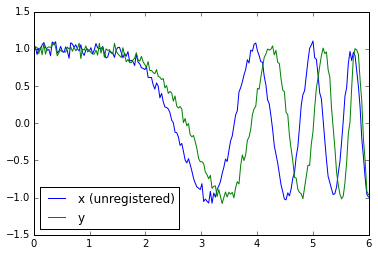

In [172]:
plt.plot(t,x,label="x (unregistered)")
plt.plot(t,y,label="y")
plt.legend(loc="best")